# Decision Tree to fit a Donut

In the following notebook, I use a standard Decision Tree from my FromScratchModule.Trees library to classify all points in a Donut Distribution as either part of the hole or the ring. We then explore the use of Bootstrap Aggretation and a Forest of trees for the same problem.

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from FromScratchModule.Trees import Tree, BaggedForest, gini, mode
from FromScratchModule.Toy import donut

# The Donut

As you can see from the below cells, the distribution is simply a 2-D shape containing an inner disk and outer ring.

In [2]:
# The Donut Distributions as seen in FromScratch.Toy.donut
def Donut(n, r, margin):
    x = np.random.randn(n, 2)
    x_donut = x[np.sqrt(np.sum(x ** 2, axis=1)) > 1] * (r + margin / 2)
    x_hole = x[np.sqrt(np.sum(x ** 2, axis=1)) <= 1] * (r - margin / 2)

    y_hole = np.zeros([x_hole.shape[0], 1])
    y_donut = np.ones([x_donut.shape[0], 1])

    x = np.vstack([x_hole, x_donut])
    y = np.vstack([y_hole, y_donut])
    return x, y

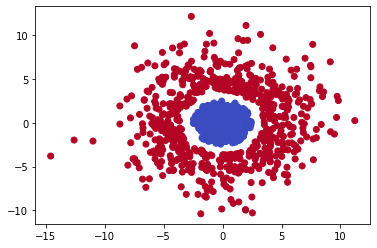

In [3]:
# Here use the donut function to create a donut of radius 3, using 1000 points each for the ring and disk 
x,y = donut(1000, 3, 1)
plt.scatter(x[:,[0]], x[:,[1]], c=y, cmap='coolwarm')

# Initializing and Fitting the Tree

As you can see, this is a very simple process using the module. With a low minimum info gain threshold, the tree can shamelessly split and fit the dataset without any sort of feature engineering. The tree is grown greedily based on separation using the gini metric for split impurity (maximizing separation per split), so it's deterministic based on these hyperparamers. With just four splits (or less) per path based on the original points, we can properly categorize all but a few points without any of the splits being overly specific or low in information gained.

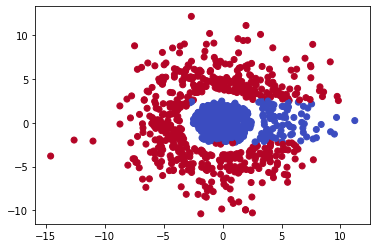

In [27]:
# Fitting with too few splits per path
model = Tree(3, gini, mode, gain_thresh=1e-2)
x_train = pd.DataFrame(x)
y_train = pd.DataFrame(y)
model.fit(x_train, y_train)
plt.scatter(x[:,[0]], x[:,[1]], c=model.predict(x_train), cmap='coolwarm')

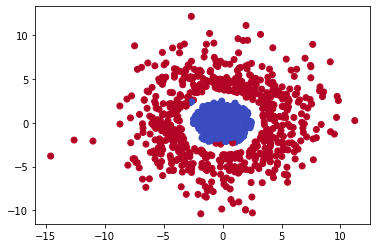

In [28]:
# Fitting with four quality splits per path
model = Tree(4, gini, mode, gain_thresh=1e-2)
model.fit(x_train, y_train)
plt.scatter(x[:,[0]], x[:,[1]], c=model.predict(x_train), cmap='coolwarm')

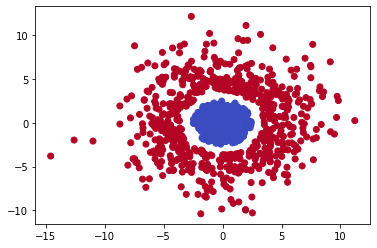

In [33]:
# Fitting with shameless, extra, low info gain splits
# This extra split effectively added extra bins for the odd points yet to be split up
model = Tree(5, gini, mode, gain_thresh=1e-3)
model.fit(x_train, y_train)
plt.scatter(x[:,[0]], x[:,[1]], c=model.predict(x_train), cmap='coolwarm')

# Radial Basis Function

But do we really need trees with so much depth? Is having around 2^5 leaves in our tree the only way to properly categorize the distribution? Not at all. One work around is to engineer a new feature out of our points like we did when performing Logistic Regression. Using the distance between points and the center as the feature, we can accoplish the task with just one split.

In [5]:
# Get the distance from each point to the center of the donut
phi = np.sqrt(x[:,[0]]**2 + x[:,[1]]**2)

np.hstack((x[:,[0]], x[:,[1]], phi))

array([[ 0.25680492, -0.23094297,  0.34537432],
       [ 1.54288395,  1.55123845,  2.18788291],
       [-1.41579177, -0.69531613,  1.57731762],
       ...,
       [ 3.52354712, -2.13622712,  4.12054009],
       [-3.71363523,  2.22873114,  4.33108867],
       [ 3.89632935, -4.02758619,  5.60382307]])

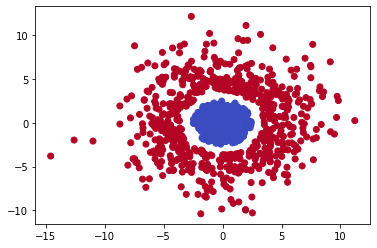

In [12]:
model = Tree(1, gini, mode)
phi_train = pd.DataFrame(phi)
model.fit(phi_train, y_train)
plt.scatter(x[:,[0]], x[:,[1]], c=model.predict(phi_train), cmap='coolwarm')

# BAgged Forests

Suppose we didn't have such a perfect domain function for our feature engineering? Can we fit the distribution using just the raw points and a shallower tree? No, but what about multiple trees? We can add some variance to what was once a deterministic process by growing multiple different trees using subsamples of the data for each. Specifically, we'll grow them using Bootstrap Aggregation, where we randomly select samples with replacement to develop different training sets for each tree. Once each tree is fit, we'll aggregate the answers of each tree to get the output of the whole group AKA Forest of trees.

We see that with a max depth of 3, we can still fit the data very well. The key here is that each tree sees only 50 data points, and learns to split without knowing the big picture. Using twenty of these locally biased trees does the trick.

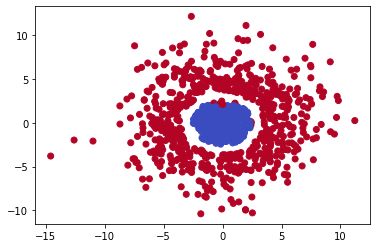

In [44]:
# Here we establish that each tree may have a depth of at most three, their splits may be somewhat wasteful,
# they see only 5 percent of the data, and that we want 20 of them.
root_tree = Tree(3, gini, mode, gain_thresh=1e-3)
model = BaggedForest(root_tree, num_trees=25, rate=0.04)
model.fit(x_train, y_train)
plt.scatter(x[:,[0]], x[:,[1]], c=model.predict(x_train), cmap='coolwarm')

# Very Stupid Trees

But can we fit the data with even shallower trees? Yes, but these trees need to see a lot less of the data, and we need a whole lot more of them. Specifically, each tree sees only 8 points, and the Forest contains 120 of them. Even with a depth of 2, training this many trees takes a while.

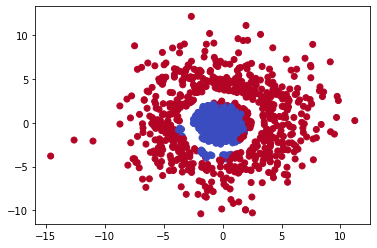

In [42]:
root_tree = Tree(2, gini, mode, gain_thresh=0)
model = BaggedForest(root_tree, num_trees=120, rate=0.008)
model.fit(x_train, y_train)
plt.scatter(x[:,[0]], x[:,[1]], c=model.predict(x_train), cmap='coolwarm')

# Summary

All in all, we see that Decision Trees and BAgged Forests are up to the task of fitting the Donut, with or without the use of a extra feature engineering. Could we have used a Random Forest (picking randomly 1 coordinate instead of both) or made our Forest with trees of depth 1? Quite possibly, but you're probably just playing with your hands tied behind your back at that point.